# Import packages

In [1]:
# Reading/Writing Data
import os
import glob
import numpy as np
import math 
import matplotlib.pyplot as plt

# Pytorch
import torch 
from torch.utils.data import DataLoader, random_split

# Self-Defined Package
from SMAPDataset import SMAPDataset
from SMCNN import SMCNN
from SDLoss import self_defined_smap_loss, ab_physics_loss_smap
from Preprocessing import random_spatial_sequence, collate_fn, collate_insitu_validation

# Some Utility Functions

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 11611801,      # Your seed number, you can pick your lucky number. :)
    'is_train': False,
    'test_ratio': 0.2,
    'valid_ratio': 0.1,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.            
    'train_batch_size': 71*2, 
    'valid_batch_size': 78,
    'test_batch_size': 197,
    'sim_threshold': 0.8,
    'learning_rate': 5e-4,
    'step_size': 15,
    'gamma': 0.5,
    'momentum': 0.9,
    'early_stop': 200,    # If model has not improved for this many consecutive epochs, stop training.     
    'root': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB',
    'model_save_dir': 'D:\\1GRADUATED\\paper\\downscaling_data\\Soil_moisture_downscale_czt\\DATASET\\AB\\OUTPUT\\MODELS\\CNN_FROM_UPSCALING'
}

# Dataloader
Read data from files and set up training, validation, and testing sets.

In [4]:
# # Set seed for reproducibility
same_seed(config['seed'])

In [5]:
# 创建数据集
dataset = SMAPDataset(config['root'])

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID
***************************Load data path******************************
valid day sequence: ['2015091', '2015104', '2015106', '2015114', '2015115', '2015117', '2015128', '2015130', '2015131', '2015136', '2015138', '2015141', '2015149', '2015154', '2015157', '2015160', '2015162', '2015163', '2015165', '2015171', '2015176', '2015186', '2015187', '2015189', '2015194', '2015195', '2015197', '2015200', '2015202', '2015203', '2015205', '2015208', '2015211', '2015213', '2015216', '2015221', '2015226', '2015229', '2015232', '2015234', '2015235', '2015237', '2015242', '2015243', '2015258', '2015259', '2015261', '2015267', '2015272', '2015275', '2015277', '2015280', '2015282', '2015283', '2015285', '2015288', '2015290', '2015291', '2015296', '2015325', '2015330', '2015333']
_______________________________2015091_______________________________
_______________________________2015104__________________________

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015221\30.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID\2015221\30.npy
_______________________________2015226_______________________________
_____________________________smap cell: 1_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015226\1.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\1.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015226\1.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID\2015226\1.npy
_____________________________smap cell: 10_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015226\10.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\A

D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015290\35.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\35.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015290\35.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID\2015290\35.npy
_____________________________smap cell: 36_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\SMAP\2015290\36.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\INPUT\TEXTURE\36.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\SMAP\2015290\36.npy
D:\1GRADUATED\paper\downscaling_data\Soil_moisture_downscale_czt\DATASET\AB\LABEL\ATI\GRID\2015290\36.npy
_____________________________smap cell: 37_____________________________
D:\1GRADUATED\paper\downscaling_data\Soil_

In [6]:
# 计算训练集和测试集的长度
train_len = int(len(dataset) * (1-config['test_ratio']))
test_len = len(dataset) - train_len

# 使用 random_split 函数进行划分
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])

# 计算训练集和验证集的长度
valid_len = int(train_len * (config['valid_ratio']))
train_len = train_len - valid_len

# 使用 random_split 函数进行划分
train_dataset, valid_dataset = random_split(train_dataset, [train_len, valid_len])

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=config['valid_batch_size'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config['test_batch_size'], shuffle=False, collate_fn=collate_fn)

print('training size', len(train_dataset))
print('validing size', len(valid_dataset))
print('testing size', len(test_dataset))

training size 710
validing size 78
testing size 197


# Training Loop

In [7]:
def trainer(train_loader, valid_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = self_defined_smap_loss 
    optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.01, lr=config['learning_rate'], momentum=config['momentum']) 
    
    # learning rate decay
    RLRP = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['gamma'], patience=config['step_size'], threshold=0.03)

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        if epoch==10:
            config['sim_threshold'] = 0.93
        model.train() # Set your model to train mode.
        
        loss_record = []
        physical_loss_record = []
        sim_loss_record = []
        for data_pkg in train_loader:
            x = data_pkg['processed_data']
            optimizer.zero_grad()               
            pred = model(x)
            relu(pred[:, 0])
#             print(pred)
#             x, pred = x.to(device), pred.to(device)  
            physical_loss, sim_loss = criterion(pred, data_pkg['label_data'], 'Training', config['sim_threshold'])
            loss = physical_loss + sim_loss
            loss.backward()                     
            optimizer.step()                   
            step += 1
            
            physical_loss_record.append(physical_loss.detach().item())
            sim_loss_record.append(sim_loss.detach().item())
            loss_record.append(loss.detach().item())
         
        mean_train_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_train_sim_loss = sum(sim_loss_record)/len(sim_loss_record)
        mean_train_loss = sum(loss_record)/len(loss_record)

        model.eval() 
        loss_record = []
        physical_loss_record = []
        sim_loss_record = []
        for data_pkg in valid_loader:
            x = data_pkg['processed_data']
            with torch.no_grad():
                pred = model(x)
                relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
                physical_loss, sim_loss = criterion(pred, data_pkg['label_data'], 'Validing', config['sim_threshold'])
                loss = physical_loss + sim_loss
            
            physical_loss_record.append(physical_loss.item())
            sim_loss_record.append(sim_loss.item())
            loss_record.append(loss.item())

        mean_valid_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
        mean_valid_sim_loss = sum(sim_loss_record)/len(sim_loss_record)
        mean_valid_loss = sum(loss_record)/len(loss_record)
        
        current_lr = (optimizer.param_groups[0])['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] (LR: {current_lr}):')
        print(f'Train loss: {mean_train_loss:.4f} || Train physical loss: {mean_train_physical_loss:.4f} || Train similarity loss: {mean_train_sim_loss:.4f}')
        print(f'Valid loss: {mean_valid_loss:.4f} || Valid physical loss: {mean_valid_physical_loss:.4f} || Valid similarity loss: {mean_valid_sim_loss:.4f}')
            
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            _name = str(best_loss)
            _name = 'first'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            _name = str(best_loss)
            _name = 'last'
            torch.save(model.state_dict(), os.path.join(config['model_save_dir'], _name + '.ckpt')) # Save your best model
            return
        #         StepLR.step()
        RLRP.step(mean_valid_loss)

# Start training!

In [8]:
# 创建模型保存目录
if os.path.exists(config['model_save_dir'])==False:
    os.makedirs(config['model_save_dir'], exist_ok=True)
    
if config['is_train']==True:
    print(dataset.get_input_shape(0))
    model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device) # put your model and data on the same computation device.
    print(model)
    trainer(train_loader, valid_loader, model, config, device)

## Testing

In [9]:
def tester(test_loader, model, config, device):
    relu = torch.nn.ReLU(inplace=True)
    criterion = self_defined_smap_loss
    model.eval() 
    loss_record = []
    physical_loss_record = []
    sim_loss_record = []
    for data_pkg in test_loader:
        x = data_pkg['processed_data']
        with torch.no_grad():
            pred = model(x)
            relu(pred[:, 0])
#             x, pred = x.to(device), pred.to(device)  
            physical_loss, sim_loss = criterion(pred, data_pkg['label_data'], 'Validing', config['sim_threshold'])
            loss = physical_loss + sim_loss

        physical_loss_record.append(physical_loss.item())
        sim_loss_record.append(sim_loss.item())
        loss_record.append(loss.item())

    mean_test_physical_loss = sum(physical_loss_record)/len(physical_loss_record)
    mean_test_sim_loss = sum(sim_loss_record)/len(sim_loss_record)
    mean_test_loss = sum(loss_record)/len(loss_record)

    print(f'Test loss: {mean_test_loss:.4f} || Valid physical loss: {mean_test_physical_loss:.4f} || Valid similarity loss: {mean_test_sim_loss:.4f}')
    return loss_record

(11, 11, 19)
SMCNN(
  (cnn): Sequential(
    (0): Conv2d(19, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3872, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
)


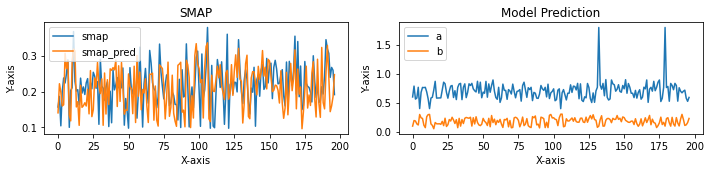

Test loss: 1.3426 || Valid physical loss: 0.0040 || Valid similarity loss: 1.3386


In [11]:
param_path = os.path.join(config['model_save_dir'],'first.ckpt' )
print(dataset.get_input_shape(0))
model = SMCNN(input_channel=dataset.get_input_shape(0)[2]).to(device)
print(model)
model.load_state_dict(torch.load(param_path))
loss_record = tester(test_loader, model, config, device) 